In [29]:
import io
!pip install librosa
!pip install jiwer
!pip install pytorch

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  Running setup.py bdist_wheel for pytorch ... error
  Complete output from command /usr/local/bin/python -u -c "import setuptools, tokenize;__file__='/tmp/pip-build-r0mhif2a/pytorch/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/tmpb5iffa45pip-wheel- --python-tag cp36:
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-build-r0mhif2a/pytorch/setup.py", line 17, in <module>
      raise Exception(message)
  Exception: You should install pytorch from http://pytorch.org
  
  ----------------------------------------
  Failed building wheel for pytorch
  

In [30]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy
import os
import torch
from torch.nn import CTCLoss
from warpctc_pytorch import CTCLoss
from ctcdecode import CTCBeamDecoder
import itertools
import jiwer

ImportError: cannot import name 'CTCLoss'

In [3]:
#Functions for file manipulation
def load_samples(file_path):
    ys, srs = [[]],[[]]
    i = 0
    #loads .wav files
    for filename in os.listdir(file_path):
        if filename.endswith(".wav"):
            y, sr = librosa.load(file_path+filename, sr=16000)
            ys[i].append(y)
            srs[i].append(sr)
            i = i + 1
            ys.append([])
            srs.append([])  
    ys = ys[0: len(ys) - 1]
    srs = srs[0: len(srs) - 1]
    return (ys, srs)


def load_labels(file_path):
    i = 0
    labels = [[]]
    
    for filename in os.listdir(file_path):
        if filename.endswith(".txt"):
            file = open(file_path+filename, "r") 
            labels[i].append(file.read())
            labels.append([])
            i = i + 1
            
    labels=labels[0: len(labels) - 1]
    return labels

In [4]:
#Functions for feature extraction
def find_max(ys):
    """
    Searches for the longest same.
    used for padding.
    ys - [num_samples] x [sample_length]
    
    returns
    max(sample_length)
    """
    
    maximum =0
    for y1 in ys:
        for y2 in y1:
            dim = y2.shape[0]
            if dim > maximum:
                maximum = dim
    return maximum

def pad_signal(ys, max_length):
    """
    pads the signal
    
    Signals are not of the same length, so samples that are shorter then longest signal are padded
    ys - [num_samples] x [sample_length]
    
    returns
    [num_samples] x [sample_length] - sample_length is now same for each sample
    """
    
    
    ys_new = ys
    for i, y1 in enumerate(ys_new):
        for j, y2 in enumerate(y1):
            if len(y2) < max_length:
                z = numpy.zeros((max_length - len(y2)))
                pad_signal = numpy.append(y2, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
                ys_new[i][j] = pad_signal
    return ys_new
def pre_emphasize(ys, pre_emphasis = 0.97):
    """
    Performs pre emphasis
    
    ys - ys - input array of all samples [num_samples] x [sample_length]
    pre_emphasis - pre emphasis factor, usually 0.97
    
    returns
    [num_samples] x [sample_length] - emphasized signal
    """
    for i, y in enumerate(ys):
        signal=y[0]
        y[0] = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return ys
def fourier_transform(ys, N_FFT=512, window='hamming', hop_size=256):
    """
    Performs stft
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    window - window function - e.g. hanning, or hamming etc.
    hop_size - self explanatory
    
    returns Ds [num_samples] x [1] x [sequence_length] x [N_FFT/2 + 1] - returns spectrogram of the sample. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ... 
    
    """
    
    Ds = [[]]

    for i, y in enumerate(ys):
        Ds[i].append(librosa.core.stft(y=y[0], n_fft=N_FFT, window=window, hop_length=hop_size))
        Ds.append([])
    return Ds

def mfccs(ys, N_FFT=512, sr=16000, n_mfcc=40, hop_size=256):
    """
    Extracts mel features
    
    ys - input array of all samples [num_samples] x [sample_length]
    N_FFT - number of FFTs
    sr - sampling rate
    n_mfcc - number of mfcc features
    hop_size - self explanatory
    
    returns
    mels [num_samples] x [1] x [sequence_length] x [n_mfcc] - returns mel features. It is a bit stupid, since there is one extra
    unncessary dimension, it`s mostly because working with numpy arrays is ...
    """
    mels = [[]]
    
    for i, y in enumerate(ys):
        mels[i].append(librosa.feature.mfcc(y[0], sr=sr, n_mfcc=n_mfcc, n_fft=N_FFT, hop_length=hop_size))
        mels.append([])
    return mels

In [5]:
def display_cost(costs, num_epochs):
    x = numpy.arange(0, num_epochs + 1, 1)
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.plot(x, costs)
    plt.show()

def greedy_decoder(outputs, all_labels):
    """
    """
    
    string=[]
    maximals, indices = outputs.max(1)
    for i in indices:
        string.append(all_labels[i])
    itertools.groupby(string)
    string=[k for k, g in itertools.groupby(string)]
    output =[]
    for s in string:
        if s != "-":
            output.append(s)
    
    print(output)
    return output
            

# Step 1
* we open the samples and labels

In [6]:
path = "an4_dataset/train/"#path to the dataset

ys, srs = load_samples(path)
labels = load_labels(path)

In [7]:
path2 = "an4_dataset/validation/"

ys_valid, srs = load_samples(path2)
labels_valid = load_labels(path2)

# Step 2
* loaded data is preprocessed
* we perform stft using librosa
* then we add melspectrogram
* and MFCCs, all are prepared, but we can use each of them, so we get different kinds of features

**Note**: For stft we have a window size, typically 512 or 256 and hop size. On each iteration we start at 
$$
n_1 = N_f x H
$$
and we finish at
$$
n_2 = n_1 + M - 1
$$

https://dsp.stackexchange.com/questions/38491/time-position-in-stft-output

H is a hop size (length) and M is a window size.

In [8]:
train_max=find_max(ys=ys)
valid_max=find_max(ys=ys_valid)
max_len= train_max if train_max>valid_max else valid_max

ys_new = pad_signal(ys, max_len)
ys_valid_new=pad_signal(ys_valid, max_len)

ys_emphasized=pre_emphasize(ys_new, 0.97)
ys_valid_emphasize=pre_emphasize(ys_valid_new, 0.97)

In [9]:
N_FFT = 400 #window size
window = 'hamming'
hop_size = 160
N_MFCC = 40

#Ds=fourier_transform(ys=ys_emphasized, N_FFT=N_FFT, window=window, hop_size=hop_size)
Ms=mfccs(ys=ys_emphasized, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)
Ms_valid=mfccs(ys=ys_valid_emphasize, n_mfcc=N_MFCC, N_FFT=N_FFT, hop_size=hop_size)

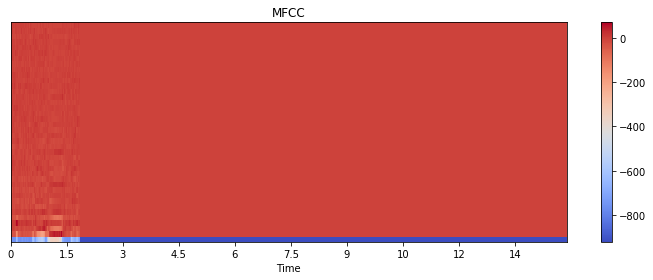

In [10]:
#Here we plot mel spectrogram of one of the samples. Since this sample is pretty 
#long, we have something over the whole time period
plt.figure(figsize=(10, 4))
librosa.display.specshow(Ms[1][0], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()


# Step 3

Here we create a neural network, define loss function (CTCLoss in our case) and optimizer.

In [11]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool1d, Dropout2d, Conv1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [22]:
# hyperameters of the model
num_classes = 28
channels = 1
height = 641
width = 40

num_filters_conv1 = 32
kernel_size_conv1 = 3 # [height, width]
stride_conv1 = 1 # [stride_height, stride_width]
padding_conv1 = 0
dilation_conv1 = 1


stride_pool1 = 2
kernel_size_pool1 = 2
padding_pool1 = 0
dilation_pool1 = 1

#convolutional layer
num_filters_conv2 = 128
kernel_size_conv2 = 3 # [height, width]
stride_conv2 = 1 # [stride_height, stride_width]
padding_conv2 = 0
dilation_conv2 = 1

stride_pool2 = 2
kernel_size_pool2 = 2
padding_pool2 = 0
dilation_pool2 = 1

#3rd convolutional layer
num_filters_conv3 = 16
kernel_size_conv3 = 3 # [height, width]
stride_conv3 = 1 # [stride_height, stride_width]
padding_conv3 = 0
dilation_conv3 = 1


stride_pool3 = 2
kernel_size_pool3 = 2
padding_pool3 = 0
dilation_pool3 = 1

#4th convolutional layer
num_filters_conv4 = 8
kernel_size_conv4 = 3 # [height, width]
stride_conv4 = 1 # [stride_height, stride_width]
padding_conv4 = 0
dilation_conv4 = 1


num_l1 = 200
dilation=1

def compute_conv_dim(dim_size):
    return int((dim_size - kernel_size_conv1 + 2 * padding_conv1) / stride_conv1 + 1)

def compute_maxPool_dim(dim_size):
    return int((dim_size - kernel_size_pool1 + 2 * padding_conv1) / stride_pool1 + 1)


def compute_conv_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)

def compute_pool_dim_1d(L_in, kernel_in, padding_in = 0, dilation_in = 1, stride_in = 1):
    return int((L_in + 2*padding_in - dilation_in*(kernel_in - 1) - 1)/stride_in + 1)
    
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        #out_dim = (input_dim - filter_dim + 2 * padding) / stride + 1
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             stride=stride_conv1,
                             padding=padding_conv1,
                             dilation=dilation_conv1)
        
        self.maxPool_1 = MaxPool1d(kernel_size=kernel_size_pool1,
                                   stride=stride_pool1,
                                   padding=padding_pool1,
                                   dilation=dilation_pool1)
        
        #self.conv_out_height = compute_conv_1d_dim(height)
        self.conv_out_width1 = compute_conv_dim_1d(L_in=width, padding_in=padding_conv1,
                                                dilation_in=dilation_conv1, kernel_in=kernel_size_conv1,
                                                stride_in=stride_conv1)
        #self.conv_out_height = compute_maxPool_dim(self.conv_out_height)
        #self.conv_out_width1 = compute_pool_dim_1d(L_in=self.conv_out_width1, padding_in=padding_pool1,
        #                                           dilation_in=dilation_pool1, kernel_in=kernel_size_pool1,
        #                                           stride_in=stride_pool1)
        
        self.conv_2 = Conv1d(in_channels=num_filters_conv1,
                             out_channels=num_filters_conv2,
                             kernel_size=kernel_size_conv2,
                             stride=stride_conv2,
                             padding=padding_conv2,
                             dilation=dilation_conv2)
        
        self.maxPool_2 = MaxPool1d(kernel_size=kernel_size_pool2,
                                   stride=stride_pool2,
                                   padding=padding_pool2,
                                   dilation=dilation_pool2)
        
        self.conv_out_width2 = compute_conv_dim_1d(L_in=self.conv_out_width1, padding_in=padding_conv2,
                                                dilation_in=dilation_conv2, kernel_in=kernel_size_conv2,
                                                stride_in=stride_conv2)
        #self.conv_out_width2 = compute_pool_dim_1d(L_in=self.conv_out_width2, padding_in=padding_pool2,
        #                                           dilation_in=dilation_pool2, kernel_in=kernel_size_pool2,
        #                                           stride_in=stride_pool2)
        
        self.conv_3 = Conv1d(in_channels=num_filters_conv2,
                             out_channels=num_filters_conv3,
                             kernel_size=kernel_size_conv3,
                             stride=stride_conv3,
                             padding=padding_conv3,
                             dilation=dilation_conv3)
        
        self.maxPool_3 = MaxPool1d(kernel_size=kernel_size_pool3,
                                   stride=stride_pool3,
                                   padding=padding_pool3,
                                   dilation=dilation_pool3)
        
        self.conv_out_width3 = compute_conv_dim_1d(L_in=self.conv_out_width2, padding_in=padding_conv3,
                                                dilation_in=dilation_conv3, kernel_in=kernel_size_conv3,
                                                stride_in=stride_conv3)
        
        #self.conv_out_width3 = compute_pool_dim_1d(L_in=self.conv_out_width3, padding_in=padding_pool3,
        #                                           dilation_in=dilation_pool3, kernel_in=kernel_size_pool3,
        #                                           stride_in=stride_pool3)
        
        
        self.conv_4 = Conv1d(in_channels=num_filters_conv3,
                             out_channels=num_filters_conv4,
                             kernel_size=kernel_size_conv4,
                             stride=stride_conv4,
                             padding=padding_conv4,
                             dilation=dilation_conv4)
        
        self.conv_out_width4 = compute_conv_dim_1d(L_in=self.conv_out_width3, padding_in=padding_conv4,
                                                dilation_in=dilation_conv4, kernel_in=kernel_size_conv4,
                                                stride_in=stride_conv4)
        
        self.l1_in_features = self.conv_out_width3*num_filters_conv3
        #self.l1_in_features = channels * height * width
        
        self.l_1 = Linear(in_features=self.l1_in_features, 
                          out_features=num_l1,
                          bias=True)
        self.l_out = Linear(in_features=num_l1, 
                            out_features=num_classes,
                            bias=False)
    
    def forward(self, x): # x.size() = [batch, channel, height, width]
        #print(x.shape)
        #(641, 1, 40)
        x = relu(self.conv_1(x))
        #torch.Size([641, 16, 38])
        #x = self.maxPool_1(x)
        #([641, 16, 19])
        x = relu(self.conv_2(x))
        #print(x.shape)
        #x = self.maxPool_2(x)
        
        x = relu(self.conv_3(x))
        #x = self.maxPool_3(x)
        #print(x.shape)
        #x = x.view(1,  641, self.l1_in_features)
        x = x.view(-1, self.l1_in_features)
        x = relu(self.l_1(x))
        
        # torch.Tensor.view: http://pytorch.org/docs/master/tensors.html?highlight=view#torch.Tensor.view
        #   Returns a new tensor with the same data as the self tensor,
        #   but of a different size.
        # the size -1 is inferred from other dimensions 
        #print(x.shape)#NCHW to HCNW
        #x=x.permute(0, 2, 1, 3)
        #print(x.shape)
        #x=x.contiguous()
        
        #print(x.shape)
        #x = self.dropout(relu(self.l_1(x)))
        #x = relu(self.l_1(x))
        #print(x.shape)
        #return torch.nn.functional.log_softmax(self.l_out(x), dim=1)
        return self.l_out(x)


net = Net()
print(net)

Net(
  (conv_1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (maxPool_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_2): Conv1d(32, 128, kernel_size=(3,), stride=(1,))
  (maxPool_2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv1d(128, 16, kernel_size=(3,), stride=(1,))
  (maxPool_3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_4): Conv1d(16, 8, kernel_size=(3,), stride=(1,))
  (l_1): Linear(in_features=544, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=28, bias=False)
)


In [23]:
criterion = CTCLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Step 4

* In here we prepare the lables - characters A - Z, space and blank character
* number of samples used for training
* number of epochs for the training

In [24]:
num_epochs = 100
valid_epochs=10
num_samples = 100
all_labels= [
    "-",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    " ",
]
print(all_labels)

['-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ' ']


# Step 5

* In here we train the network

With batch

In [28]:
print(len(Ms[0][0][0]))
counter = 0
batch_size = 20
ctc_loss = torch.nn.CTCLoss()
for i in range(int(num_samples/batch_size)):
    net.train()
    
    sample = numpy.empty([1,1, 641 * batch_size, 40])
    ground_truth_sizes = torch.empty(batch_size)
    probs_sizes = torch.empty(batch_size)
    
    ground_truth_string_int = []
    for j in range(batch_size):
        sample[0][0][j * 641 : (j + 1) * 641] = Ms[i * batch_size + j][0].T
        
        string = ''.join(labels[i * batch_size + j])
        
        ground_truth_sizes[j] = len(string)
        probs_sizes[j] = 641
        
        for character in string:
            if(character == " "):
                number = 27
            else:
                number = ord(character) - 64
            ground_truth_string_int.append(number)
    
    print("Len of truth: " + str(len(ground_truth_string_int)))
    print("sum of truths: " + str(sum(ground_truth_sizes)))
    
    ground_truth = torch.IntTensor(ground_truth_string_int)
    sample_1 = sample[0].reshape((12820,1, 40))
    print("going into network.")
    out = net(Variable(torch.from_numpy(sample_1).float()))
    
    print("out:")
    print(out.shape)
    out_batch = torch.empty([batch_size, 641, 28])
    for j in range(batch_size):
        out_batch[j] = out[j * 641 : (j + 1) * 641]
        
    print("out_batch:")
    print(out_batch.shape)
    print("probs sizes: " + str(probs_sizes))
    
    #run the criterion
    optimizer.zero_grad()
        
    print(ground_truth.shape)
        
    #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
    cost=criterion(out_batch, torch.tensor(ground_truth_string_int).int(), probs_sizes.int(), ground_truth_sizes.int())
    cost.backward()
    optimizer.step()
    
    print(cost)
    
    
        

641


AttributeError: module 'torch.nn' has no attribute 'CTCLoss'

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.1295166015625
269.1295166015625
['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
362.7732849121094
362.7732849121094
Cost: 
269.9414367675781
269.9414367675781


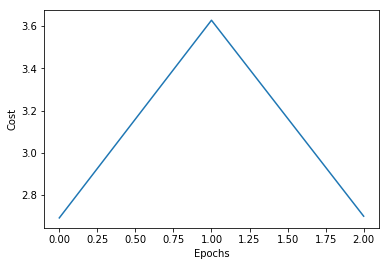

Cost: 
297.0366516113281
297.0366516113281
Cost: 
324.64617919921875
324.64617919921875


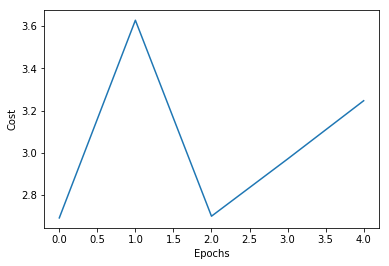

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
320.9991760253906
320.9991760253906
Cost: 
301.62255859375
301.62255859375


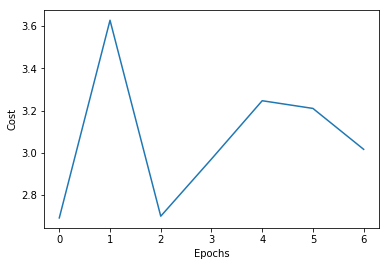

Cost: 
278.8529357910156
278.8529357910156
Cost: 
269.5904846191406
269.5904846191406


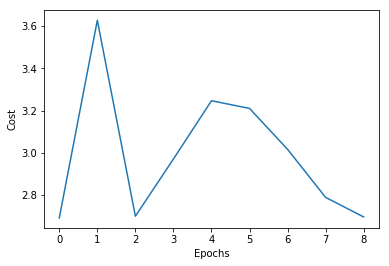

Cost: 
280.4211120605469
280.4211120605469
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
294.6597595214844
294.6597595214844


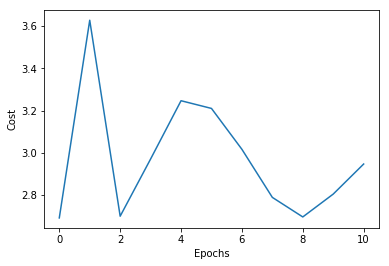

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
293.03216552734375
293.03216552734375
Cost: 
280.5912170410156
280.5912170410156


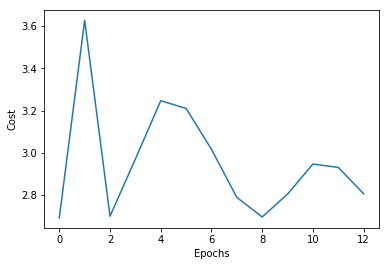

Cost: 
270.9571533203125
270.9571533203125
Cost: 
269.7593994140625
269.7593994140625


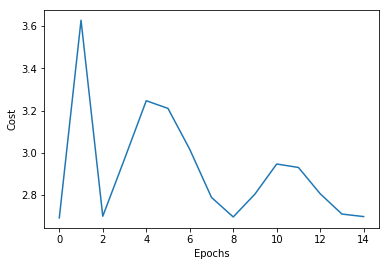

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
274.2918395996094
274.2918395996094
Cost: 
278.9573669433594
278.9573669433594


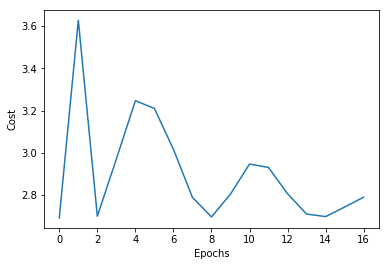

Cost: 
280.69854736328125
280.69854736328125
Cost: 
278.3966979980469
278.3966979980469


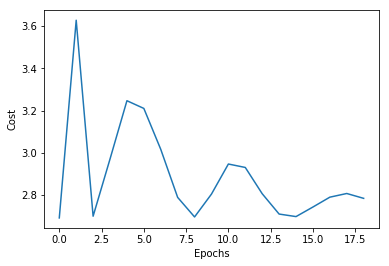

Cost: 
274.2893981933594
274.2893981933594
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
270.61224365234375
270.61224365234375


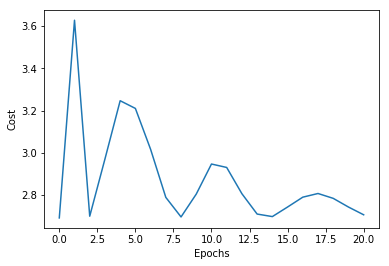

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.4367980957031
269.4367980957031
Cost: 
271.1492614746094
271.1492614746094


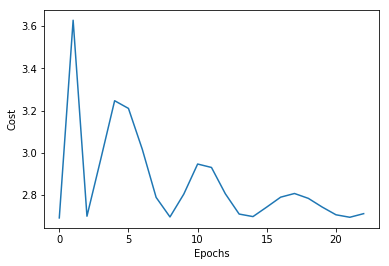

Cost: 
273.7102966308594
273.7102966308594
Cost: 
274.6294250488281
274.6294250488281


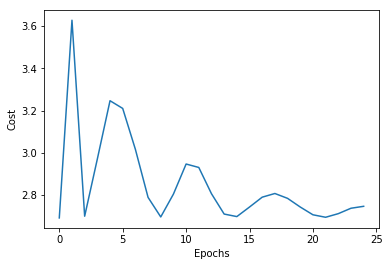

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
273.0259704589844
273.0259704589844
Cost: 
270.6460876464844
270.6460876464844


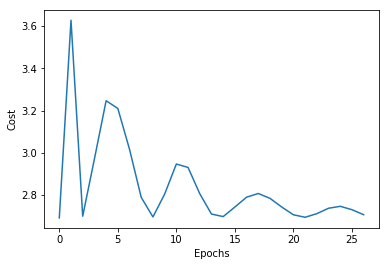

Cost: 
269.321533203125
269.321533203125
Cost: 
269.5511779785156
269.5511779785156


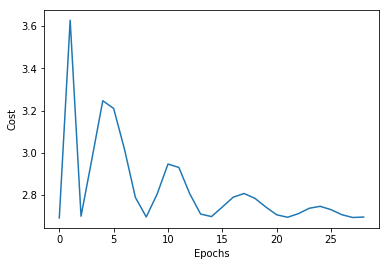

Cost: 
270.68096923828125
270.68096923828125
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
271.67852783203125
271.67852783203125


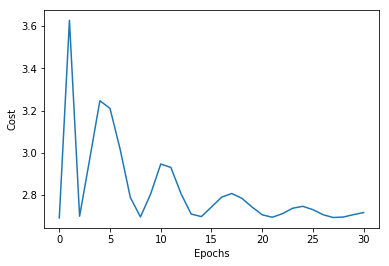

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
271.6953430175781
271.6953430175781
Cost: 
270.83563232421875
270.83563232421875


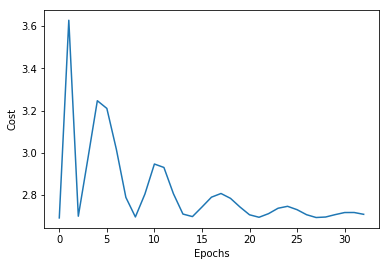

Cost: 
269.7480163574219
269.7480163574219
Cost: 
269.3551025390625
269.3551025390625


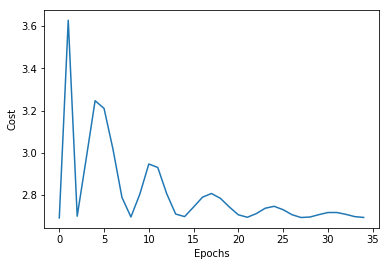

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.915771484375
269.915771484375
Cost: 
270.6333312988281
270.6333312988281


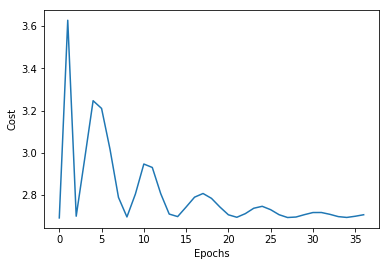

Cost: 
270.5218811035156
270.5218811035156
Cost: 
269.8701171875
269.8701171875


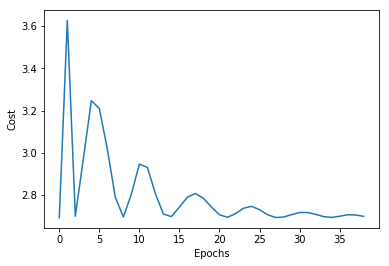

Cost: 
269.28851318359375
269.28851318359375
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.5008544921875
269.5008544921875


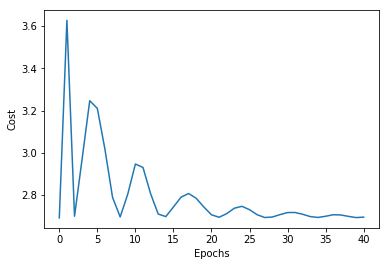

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.7578430175781
269.7578430175781
Cost: 
269.7596740722656
269.7596740722656


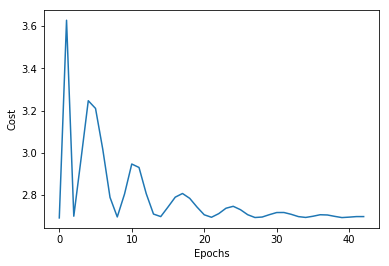

Cost: 
269.46185302734375
269.46185302734375
Cost: 
269.1753234863281
269.1753234863281


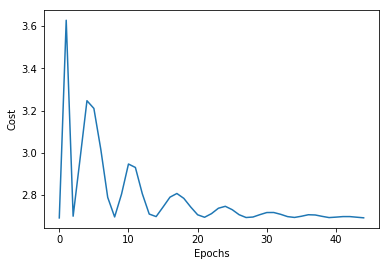

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.1346435546875
269.1346435546875
Cost: 
269.2824401855469
269.2824401855469


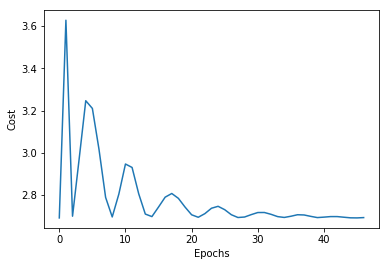

Cost: 
269.31488037109375
269.31488037109375
Cost: 
269.2488098144531
269.2488098144531


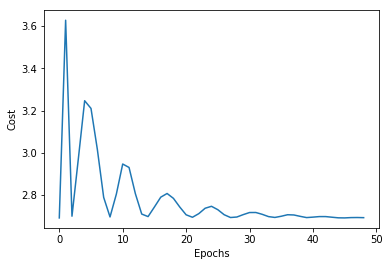

Cost: 
269.12908935546875
269.12908935546875
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.09222412109375
269.09222412109375


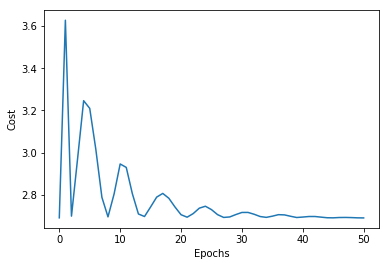

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.1867370605469
269.1867370605469
Cost: 
269.24774169921875
269.24774169921875


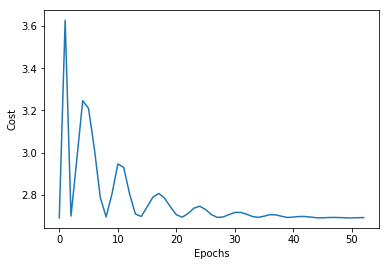

Cost: 
269.20465087890625
269.20465087890625
Cost: 
269.0956115722656
269.0956115722656


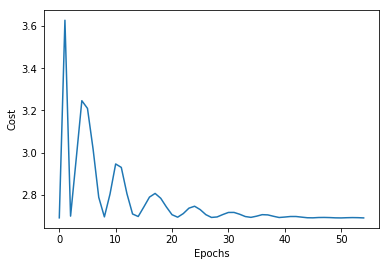

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.0740051269531
269.0740051269531
Cost: 
269.1210632324219
269.1210632324219


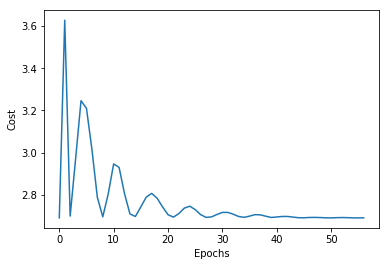

Cost: 
269.1269226074219
269.1269226074219
Cost: 
269.08428955078125
269.08428955078125


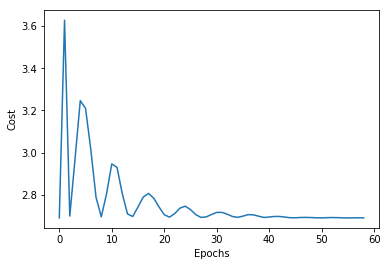

Cost: 
269.0500183105469
269.0500183105469
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.06475830078125
269.06475830078125


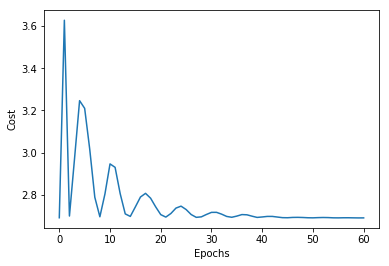

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.0967712402344
269.0967712402344
Cost: 
269.0870361328125
269.0870361328125


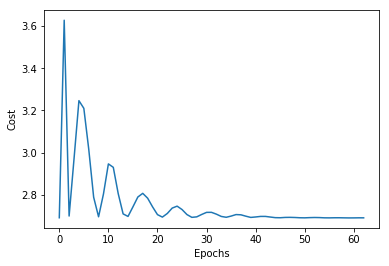

Cost: 
269.0814514160156
269.0814514160156
Cost: 
269.0501403808594
269.0501403808594


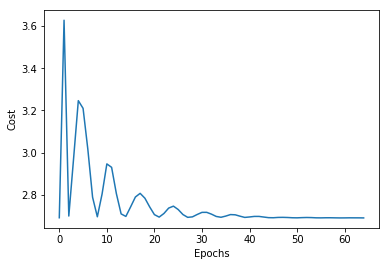

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.0453796386719
269.0453796386719
Cost: 
269.0653381347656
269.0653381347656


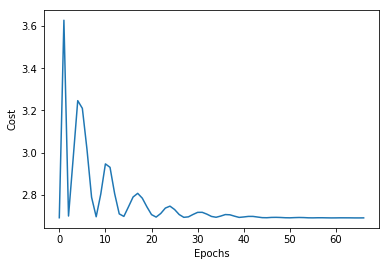

Cost: 
269.0782775878906
269.0782775878906
Cost: 
269.06219482421875
269.06219482421875


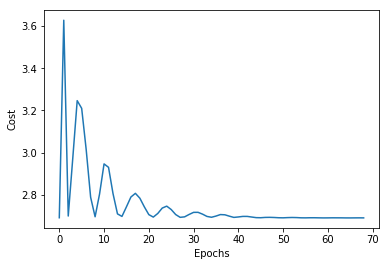

Cost: 
269.0399475097656
269.0399475097656
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.0667419433594
269.0667419433594


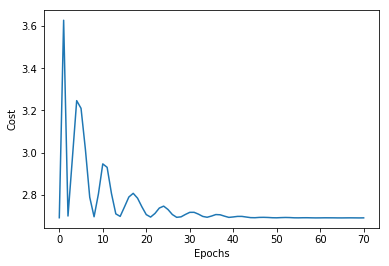

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.1145935058594
269.1145935058594
Cost: 
269.100830078125
269.100830078125


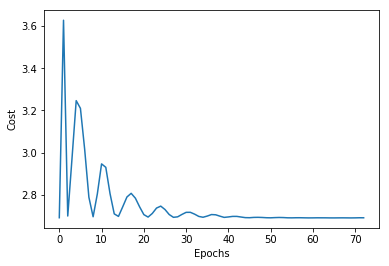

Cost: 
269.0683898925781
269.0683898925781
Cost: 
269.036376953125
269.036376953125


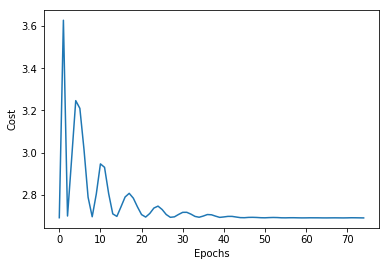

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.04583740234375
269.04583740234375
Cost: 
269.0601806640625
269.0601806640625


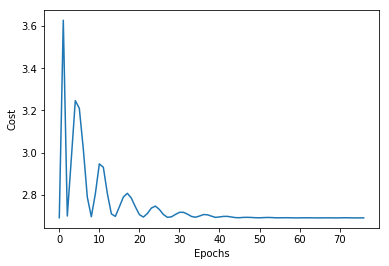

Cost: 
269.0460205078125
269.0460205078125
Cost: 
269.03521728515625
269.03521728515625


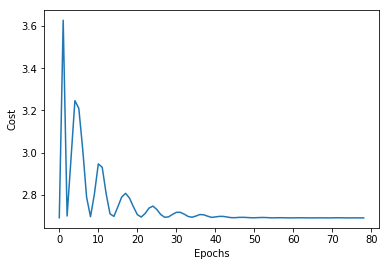

Cost: 
269.03912353515625
269.03912353515625
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.03759765625
269.03759765625


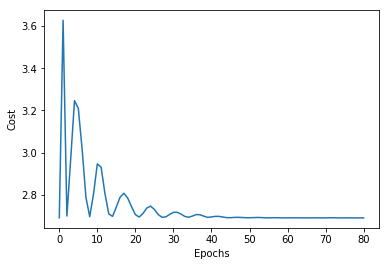

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.0343322753906
269.0343322753906
Cost: 
269.0323181152344
269.0323181152344


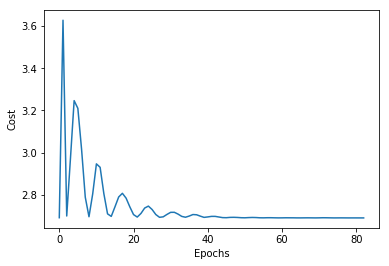

Cost: 
269.0328063964844
269.0328063964844
Cost: 
269.0338134765625
269.0338134765625


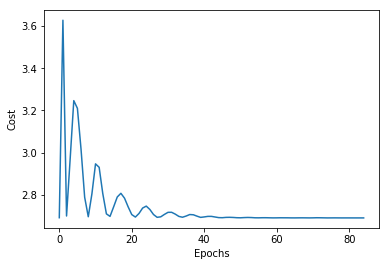

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.0320129394531
269.0320129394531
Cost: 
269.0345153808594
269.0345153808594


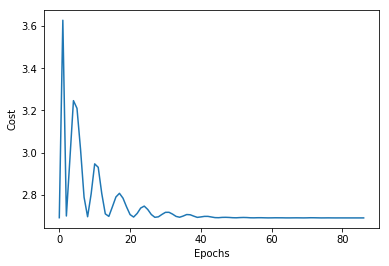

Cost: 
269.0362854003906
269.0362854003906
Cost: 
269.03924560546875
269.03924560546875


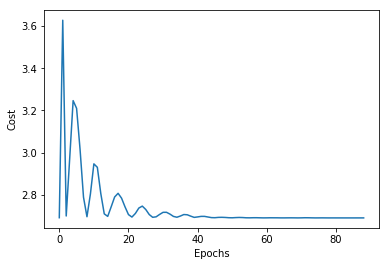

Cost: 
269.0450744628906
269.0450744628906
['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.05047607421875
269.05047607421875


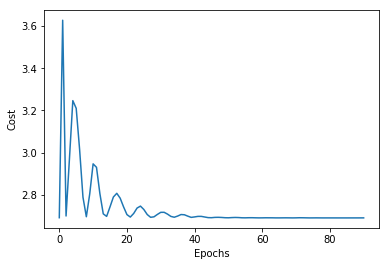

['J C H E Q FIFTY EIGHT THOUSAND NINE THIRTY NINE']
Cost: 
269.0516052246094
269.0516052246094
Cost: 
269.04779052734375
269.04779052734375


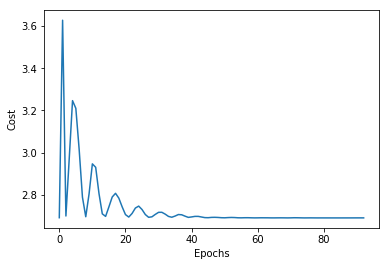

Cost: 
269.0412292480469
269.0412292480469
Cost: 
269.03814697265625
269.03814697265625


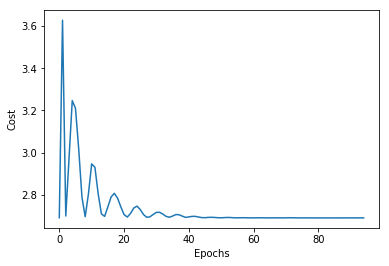

['J']
[10, 27, 3, 27, 8, 27, 5, 27, 17, 27, 6, 9, 6, 20, 25, 27, 5, 9, 7, 8, 20, 27, 20, 8, 15, 21, 19, 1, 14, 4, 27, 14, 9, 14, 5, 27, 20, 8, 9, 18, 20, 25, 27, 14, 9, 14, 5]
Cost: 
269.0368347167969
269.0368347167969
Cost: 
269.0374755859375
269.0374755859375


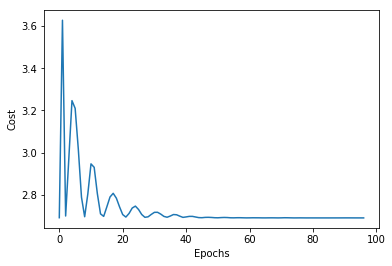

Cost: 
269.0397644042969
269.0397644042969
Cost: 
269.0382080078125
269.0382080078125


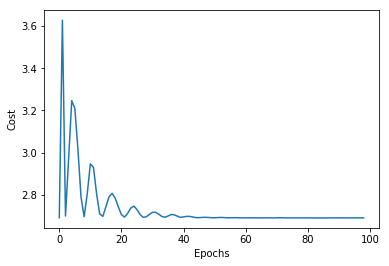

Cost: 
269.03973388671875
269.03973388671875


In [19]:
i = 0

costs=[]
while i < num_epochs:
    j=0
    
    net.train()
    avg_cost = 0
    while j < num_samples:
        #here we select a sample Ms is in format [number of samples][1][sequence_length][num_features]
        sample = numpy.empty([1,1, 641, 40])
        sample[0][0] = Ms[j][0].T
        sample_1 = sample[0].reshape((641,1, 40))
        
        #output from the NN
        out = net(Variable(torch.from_numpy(sample_1).float()))
        maximal, indices = out[0].max(1)
        
            
        
        #changes string to numbers - classes are 28 and class 0 - 25 should be A-Z, 26 is space and 27 blank
        string = ''.join(labels[j])
        ground_truth_string_int = []
        for character in string:
            if(character == " "):
                number = 27
            else:
                number = ord(character) - 64
            ground_truth_string_int.append(number)
        
        if(j%20 == 0 and i%5 == 0):
            greedy_decoder(out[0], all_labels)
            print(ground_truth_string_int)
        #construct ground truth tensor
        ground_truth = torch.IntTensor(ground_truth_string_int)

        
        #length of the ground truth sample
        ground_truth_sizes = torch.IntTensor([len(ground_truth)])
        
        
        #length of sequence - 641 in our case
        probs_sizes = torch.IntTensor([out.shape[1]])
        
        
        #run the criterion
        optimizer.zero_grad()
        
        
        
        #input must be in shape seq_length x batch size x outputs -> 641 x 1 x 28/27 (depends if we use spaces or not)
        cost=criterion(out.transpose(0,1).contiguous(), ground_truth, probs_sizes, ground_truth_sizes)
        cost.backward()
        optimizer.step()
        
        
        #we try to display our current cost
        if (i%1==0):
            print("Cost: ")
            print(cost.item())
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=ground_truth_sizes)
            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string) #uncomment this line to display the 'result'
        j = j + 1
        avg_cost = avg_cost + cost.item()
        print(avg_cost)
    avg_cost = avg_cost / num_samples
    costs.append(avg_cost)
    
    
    #plots the average cost
    if(i%2 == 0 and i > 0):
        display_cost(costs, i)
        
    net.eval()
    #evaluation not really implemented yet.    
    if(i%valid_epochs == 0):
        net.eval()
        with torch.no_grad():
            sample = numpy.empty([1,1, 641, 40])
            sample[0][0] = Ms[0][0].T
            sample_1 = sample[0].reshape(641, 1, 40)



            out = net(Variable(torch.from_numpy(sample_1).float()))
            
            string = ''.join(labels[0])
            output = []
            for character in string:
                if(character == " "):
                    number = 26
                else:
                    number = ord(character) - 65
                output.append(number)

            labels_crit = torch.IntTensor(output)

            label_sizes = torch.IntTensor([len(labels_crit)])
            beam_decoder = CTCBeamDecoder(all_labels, blank_id=27)
            beam_res, beam_scores, timesteps, sequence_lens = beam_decoder.decode(probs=out, seq_lens=label_sizes)


            for j, beam in enumerate(beam_res[0]):
                output_string = ''.join([all_labels[x] for x in beam[0:sequence_lens[0][j]]])
                #print(output_string)
            #print(output_string)
            print(labels[0])
    i = i + 1

# References

Up until this point we used various different libraries.

* For CTC cost we are using a warp-ctc function created by BAIDU which was recommended here: https://distill.pub/2017/ctc/
* It was also used in DeepSpeech: https://github.com/SeanNaren/deepspeech.pytorch - we use different architecture and many things are different, since warp-ctc does not contain much documentation, we had to check out the implementation. In the end this one was only useful to search for the libraries.

* Libraries we used:

  * warp-ctc pytorch binding - to know how to use this one, we had to play with the unit tests, since the library hardly contains any documentation.
  
  https://github.com/SeanNaren/warp-ctc
  
  * ctcdecode - for beamsearch to construct the string in the evaluation. We still have problem to understand how to build it properly though.
  
  https://github.com/githubharald/CTCDecoder
  
  * Both of the libraries lack much documentation are difficult to understand